gs://msca-bdp-tweets/final_project. 

## Load lib

In [2]:
# Update environment (if needed)
# !sudo apt update

# Download and install Java
!sudo apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install Apache Spark 3.0.3 with Hadoop 3.2
!wget -nc -q https://downloads.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz

# Unzip the folder
!tar xf  spark-3.0.3-bin-hadoop3.2.tgz

# Install findspark library that will locate Spark on the system
!pip install -q findspark

E: Package 'openjdk-8-jdk-headless' has no installation candidate


In [3]:
# Setting the environment variables, to enable running PySpark in Colab environment.

import os
import shutil
from itertools import islice
import requests

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop3.2"

In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
#from pyspark.sql import functions as F
from pyspark.sql.types import *

from pyspark.sql.functions import mean, stddev

# Create spark_session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

import sys
print(sys.version)
print(spark.version)

3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49) 
[GCC 7.5.0]
3.0.1


In [5]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read Data

In [6]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [7]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [7]:
directory = 'gs://msca-bdp-tweets/final_project/'
file = '*.json'
path = directory + file
#path = directory

In [8]:
cmd = 'hadoop fs -du -s -h ' + directory

p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
for line in p.stdout.readlines():
    print (line)
    
retval = p.wait()

156.2 G  156.2 G  gs://msca-bdp-tweets/final_project



In [9]:
%%time

tweets_df = spark.read.json(path)

CPU times: user 41.9 ms, sys: 14.6 ms, total: 56.5 ms
Wall time: 4min 18s


## EDA

In [10]:
%%time

tweets_df.count()

CPU times: user 6.47 ms, sys: 8.48 ms, total: 15 ms
Wall time: 1min 15s


25191000

In [27]:
pd.set_option("max_colwidth", 1000)
tweets_df.describe()

summary,contributors,created_at,favorite_count,filter_level,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,lang,quote_count,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,source,text,timestamp_ms
count,0,25191000,25191000,25191000,25191000,25191000,3332829,3181701,3181701,3332829,3332829,25191000,25191000,5238622,5238622,25191000,25191000,25191000,25191000,25191000
mean,null,null,0.0,null,1.453838088871457...,1.453838088871457...,Infinity,1.453092037554489...,1.453092037554489...,4.482970009158758...,4.482970009158758...,null,0.0,1.451420487744112...,1.451420487744112...,0.0,0.0,null,null,1.635456986049065...
stddev,null,null,0.0,null,2.980993718097450...,2.980993718097450...,NaN,1.403312255886593E16,1.403312255886593E16,5.858283007481441...,5.858283007481441...,null,0.0,1.934290822993775...,1.934290822993775...,0.0,0.0,null,null,7.107242865795615E8
min,null,Fri Nov 05 00:00:...,0,low,1448850337247367173,1448850337247367173,000000001404072,15754281,1001725136045793280,12,1000002715999784961,en,0,1403739068,1000324596757942272,0,0,"<a href=""HTTP://b...",! An extremely s...,1634267813394
max,null,Wed Oct 27 23:59:...,0,low,1459021442469666820,1459021442469666820,zzzzzz_cz17,1459021295652204545,999297742034923520,1458982120475398146,999996275184619520,en,0,1459020844458520587,999652465548054533,0,0,"<a href=""https://...",🫖After a long CO...,1636692793849


In [11]:
tweets_df.select('is_quote_status','retweeted_status','text','timestamp_ms','truncated','user','withheld_in_countries').show(10)
tweets_df.select('user').show(10)


+---------------+--------------------+--------------------+-------------+---------+--------------------+---------------------+
|is_quote_status|    retweeted_status|                text| timestamp_ms|truncated|                user|withheld_in_countries|
+---------------+--------------------+--------------------+-------------+---------+--------------------+---------------------+
|           true|[,, Sat Oct 30 02...|RT @LilNasX: y’al...|1635562341417|    false|[false, Sun May 2...|                 null|
|          false|                null|“At a political f...|1635562341604|     true|[false, Mon Feb 2...|                 null|
|          false|                null|@GarrAarghHrumph ...|1635562341946|    false|[false, Mon May 2...|                 null|
|           true|[,, Sat Oct 30 02...|RT @Denise_Old_La...|1635562342062|    false|[false, Sun Mar 2...|                 null|
|           true|[,, Sat Oct 30 02...|RT @LilNasX: y’al...|1635562342041|    false|[false, Fri May 0...|       

## Filter df based on covid

In [11]:
tweets_df_cleaned=tweets_df.select('coordinates','created_at', 'geo','id_str','place', 'lang',
                                   'is_quote_status','quote_count','quoted_status','quoted_status_id_str',
                                   'retweeted','retweet_count','retweeted_status','text',
                                   'timestamp_ms','user')

In [12]:
tweets_df_covid=tweets_df_cleaned.filter(tweets_df_cleaned.text.contains('covid')|\
                                         tweets_df_cleaned.text.contains('COVID')|\
                                         tweets_df_cleaned.text.contains('Covid')|\
                                         tweets_df_cleaned.text.contains('Coronavirus')|\
                                         tweets_df_cleaned.text.contains('coronavirus'))

In [13]:
tweets_df_covid.count()

15023688

In [13]:
df_concat=tweets_df_covid.dropDuplicates()

In [15]:
df_concat.count()

15018765

In [15]:
#df_concat_5000=df_concat.limit(5000)

In [16]:
import pandas as pd

table1 = {'type_count': ['Retweet count','Original tweet count'],
          'actual_count':  ['10681137','4337628'],
        }

df11 = pd.DataFrame(table1)
df11['actual_count']=pd.to_numeric(df11['actual_count'])
print (df11)

             type_count  actual_count
0         Retweet count      10681137
1  Original tweet count       4337628


In [17]:
df11.index=df11.type_count

<AxesSubplot:title={'center':'Tweet count by types'}, ylabel='actual_count'>

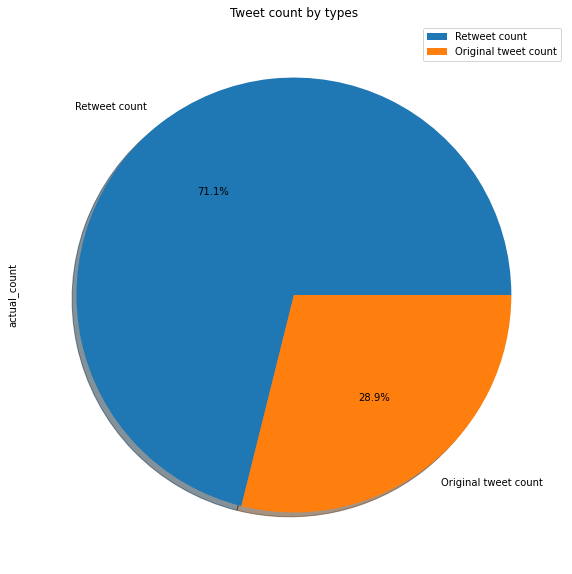

In [18]:
df11.plot.pie(y='actual_count', title="Tweet count by types",\
                                  figsize=(15, 10),autopct='%1.1f%%',legend=True, shadow=True, startangle=0)

In [16]:
df_concat.filter(df_concat.retweeted_status.isNotNull()).count()

10681137

In [17]:
df_concat.filter(df_concat.retweeted_status.isNull()).count()

4337628

In [23]:
df_geocoord.count()

69591

## Flatten columns

In [22]:
df_geocoord=df_concat.select('id_str','geo', 'place','coordinates').filter(df_concat.place.isNotNull())
df_time=df_concat[['id_str','created_at']]
#df_text=df_concat[['id_str','text']]

In [24]:
import pyspark.sql.functions as F

def flatten_df(nested_df):
    flat_cols = [c[0] for c in nested_df.dtypes if c[1][:6] != 'struct']
    nested_cols = [c[0] for c in nested_df.dtypes if c[1][:6] == 'struct']

    flat_df = nested_df.select(flat_cols +
                               [F.col(nc+'.'+c).alias(nc+'_'+c)
                                for nc in nested_cols
                                for c in nested_df.select(nc+'.*').columns])
    return flat_df

In [25]:
df_geocoord_f=flatten_df(df_geocoord)

In [55]:
df_user=df_concat.select('id_str','text','retweeted','retweet_count','user','retweeted_status').\
withColumn("original_or_not", when(df_concat.retweeted_status.isNull(), 1).otherwise(0))


In [56]:
df_user=df_user.select('id_str','text','retweeted','retweet_count','user','original_or_not')
df_user_f=flatten_df(df_user)

## Timeline

In [11]:
#Read df parquet 
output_directory = 'gs://msca-bdp-students-bucket/shared_data/charleneyu/df_time'
df_time=spark.read.parquet(output_directory)

In [14]:
df_time=df_concat.select('id_str','created_at','retweeted_status').\
withColumn("original_or_not", when(df_concat.retweeted_status.isNull(), 1).otherwise(0))

In [15]:
df_time=df_time.withColumn("dayofweek", df_time["created_at"].substr(0, 3)).\
withColumn("day", df_time["created_at"].substr(9, 2 )).\
withColumn("month_name", df_time["created_at"].substr(5, 3)).\
withColumn("year", df_time["created_at"].substr(-5, 5))

In [16]:
from pyspark.sql.functions import unix_timestamp
df_time=df_time.withColumn("month",from_unixtime(unix_timestamp(col("month_name"),'MMM'),'MM'))

In [17]:
df_time=df_time.withColumn("datefull" ,concat(df_time["year"],lit("/"),df_time["month"],lit("/"),df_time["day"]) )

In [18]:
pd.set_option("max_colwidth", 1000)
df_time.show(2)

+-------------------+--------------------+--------------------+---------------+---------+---+----------+-----+-----+-----------+
|             id_str|          created_at|    retweeted_status|original_or_not|dayofweek|day|month_name| year|month|   datefull|
+-------------------+--------------------+--------------------+---------------+---------+---+----------+-----+-----+-----------+
|1451998266204241923|Sat Oct 23 19:45:...|[,, Sat Oct 23 19...|              0|      Sat| 23|       Oct| 2021|   10| 2021/10/23|
|1451998411188670467|Sat Oct 23 19:46:...|[,, Fri Oct 22 12...|              0|      Sat| 23|       Oct| 2021|   10| 2021/10/23|
+-------------------+--------------------+--------------------+---------------+---------+---+----------+-----+-----+-----------+
only showing top 2 rows



In [ ]:
df_time_byday0=df_time.filter(df_time.original_or_not=='0').groupBy('datefull').agg(count('id_str').alias('rewteet_count')).\
orderBy('datefull', ascending=True)
df_time_byday1=df_time.filter(df_time.original_or_not=='1').groupBy('datefull').agg(count('id_str').alias('original_tweet_count')).\
orderBy('datefull', ascending=True)

df_time_byday0=df_time_byday0.join(df_time_byday1,'datefull','outer')

df_time_byday0.show(2)

+-----------+-------------+--------------------+
|   datefull|rewteet_count|original_tweet_count|
+-----------+-------------+--------------------+
| 2021/10/31|       301726|              113991|
| 2021/10/15|       347499|              149638|
+-----------+-------------+--------------------+
only showing top 2 rows



In [23]:

# importing package
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[Text(0, 0.5, 'Tweet Count'), Text(0.5, 0, 'Date')]

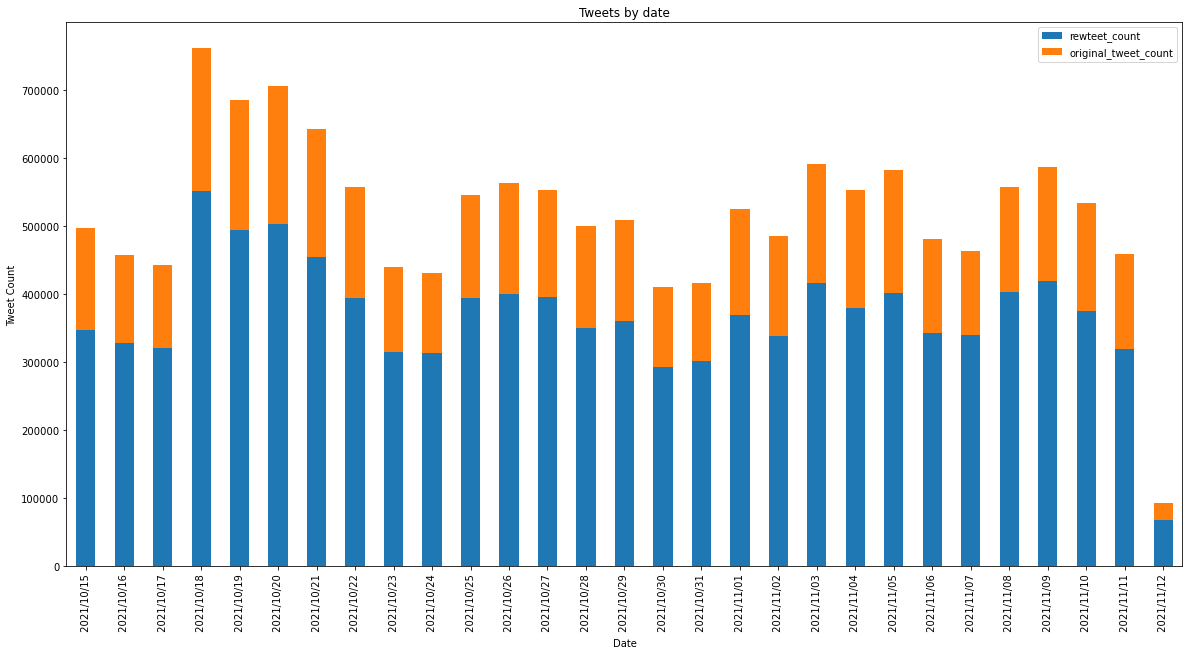

In [ ]:
# plot data in stack manner of bar type
ax=df_time_byday0.orderBy('datefull', ascending=True).toPandas().plot(x='datefull', kind='bar', stacked=True,legend=True, title="Tweets by date",figsize=(20,10))
ax.set(ylabel='Tweet Count', xlabel='Date')

[Text(0, 0.5, 'Tweet Count'), Text(0.5, 0, 'Date')]

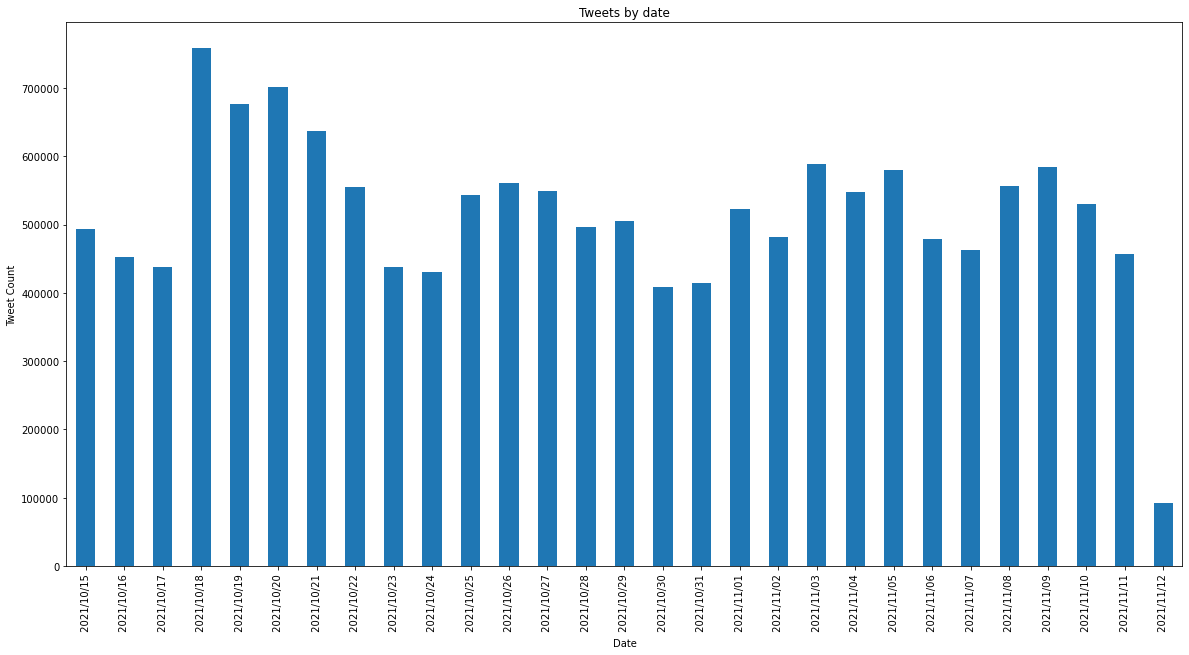

In [ ]:
df_time_byday=df_time.groupBy('datefull').agg(count('id_str')).orderBy('datefull', ascending=True).toPandas()
ax =df_time_byday.plot(kind='bar',x='datefull', y='count(id_str)', legend=None, title="Tweets by date",figsize=(20,10))

ax.set(ylabel='Tweet Count', xlabel='Date')


In [54]:
df_time_dayofweek=df_time.groupBy("dayofweek").agg(count("id_str"))
df_time_dayofweek=df_time_dayofweek.withColumn("order",\
                                               when(df_time_dayofweek.dayofweek=="Mon", 1).\
                                               when(df_time_dayofweek.dayofweek=="Tue", 2).\
                                               when(df_time_dayofweek.dayofweek=="Wed", 3).\
                                               when(df_time_dayofweek.dayofweek=="Thu", 4).\
                                               when(df_time_dayofweek.dayofweek=="Fri", 5).\
                                               when(df_time_dayofweek.dayofweek=="Sat", 6).\
                                               otherwise(7))

NameError: name 'plt' is not defined

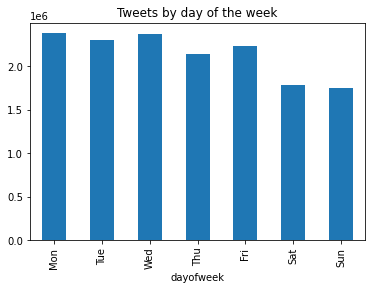

In [55]:
df_time_dayofweek.orderBy('order',ascending=True).toPandas().plot(kind='bar',x='dayofweek', y='count(id_str)', legend=None,title="Tweets by day of the week")


In [ ]:
#save table as parquet
output_directory = 'gs://msca-bdp-students-bucket/shared_data/charleneyu/df_time'
df_time.write.format("parquet").\
mode('overwrite').\
save(output_directory)

In [92]:
URL_DATASET = r'https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv'
df1 = pd.read_csv(URL_DATASET)
print(df1.head(3))  # Get first 3 entries in the dataframe

         Date      Country  Confirmed  Recovered  Deaths
0  2020-01-22  Afghanistan          0          0       0
1  2020-01-23  Afghanistan          0          0       0
2  2020-01-24  Afghanistan          0          0       0


In [93]:
df1['Date']=pd.to_datetime(df1['Date'])
df_daily_covid_cases=df1[(df1['Date'] < '2021-11-13') & (df1['Date'] > '2021-10-14')]
df_daily_covid_cases=df_daily_covid_cases.groupby(['Date']).sum()

In [94]:
df_daily_covid_cases=df_daily_covid_cases.reset_index()
df_daily_covid_cases.columns = df_daily_covid_cases.columns.str.replace('Date', 'datefull')

In [ ]:
from datetime import date
df_daily_covid_cases['datefull']=df_daily_covid_cases['datefull'].dt.strftime('%Y/%m/%d')
df_daily_covid_cases.datefull=df_daily_covid_cases.datefull.astype(str)
df_daily_covid_cases.datefull=df_daily_covid_cases.datefull.str.replace(' ', '')
df_time_byday.datefull = df_time_byday.datefull.astype(str) 
df_time_byday.datefull = df_time_byday.datefull.str.replace(' ', '')

In [ ]:
df_daily_comb= pd.merge( df_time_byday, df_daily_covid_cases,on="datefull" ,how='left')

In [101]:
df_daily_comb['Confirmed_norm']=(df_daily_comb['Confirmed']-df_daily_comb['Confirmed'].mean())/df_daily_comb['Confirmed'].std()

In [102]:
df_daily_comb['tweet_count_norm']=(df_daily_comb['count(id_str)']-df_daily_comb['count(id_str)'].mean())/df_daily_comb['count(id_str)'].std()

[Text(0, 0.5, 'Tweet Count'), Text(0.5, 0, 'Date')]

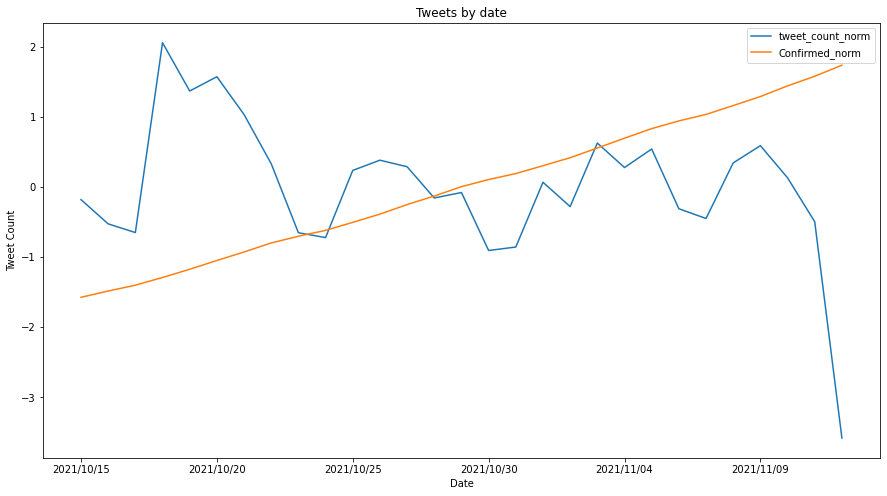

In [104]:

ax =df_daily_comb.plot(kind='line',x='datefull', y=['tweet_count_norm','Confirmed_norm'],  title="Tweets by date",figsize=(15,8))

ax.set(ylabel='Tweet Count', xlabel='Date')

## Location Analysis

In [18]:
#save table as parquet
output_directory = 'gs://msca-bdp-students-bucket/shared_data/charleneyu/df_loc'
df_geocoord_f.write.format("parquet").\
mode('overwrite').\
save(output_directory)

In [31]:
df_loc_cleaned=df_geocoord_f.groupBy('place_country_code').agg(count('id_str').alias('count_tw'))

In [33]:
df_loc_cleaned.orderBy('count_tw', acending=False).toPandas()

,place_country_code,count_tw
0,TV,1
1,VG,1
2,LI,1
3,VA,1
4,GG,1
...,...,...
181,AU,2684
182,IN,3281
183,CA,4076
184,GB,13270


In [20]:
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [21]:
iso2 = spark.read.csv('gs://msca-bdp-students-bucket/shared_data/charleneyu/iso2/', header='true', inferSchema='true', sep=',', quote='"')
iso2=iso2.withColumnRenamed('Alpha-2 code', 'place_country_code').\
withColumnRenamed('Alpha-3 code', 'iso_a3')

In [22]:
df_loc_final=df_loc_cleaned.join(iso2,'place_country_code', 'left').select('place_country_code', 'iso_a3','count_tw').toPandas()


In [23]:
df_loc_final

,place_country_code,iso_a3,count_tw
0,MM,MMR,9
1,LT,LTU,4
2,DZ,DZA,1
3,TC,TCA,4
4,CI,CIV,2
...,...,...,...
181,SR,SUR,1
182,DK,DNK,36
183,CD,COD,4
184,TJ,TJK,2


In [24]:
df_test_left  = world.merge(df_loc_final, on='iso_a3', how='left')
test2 = gpd.GeoDataFrame(df_test_left)

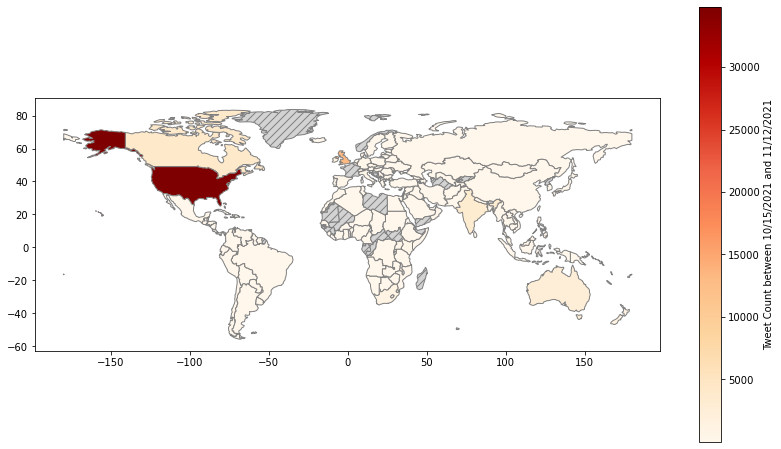

In [40]:
test2 = test2[(test2.pop_est>0) & (test2.name!="Antarctica")]
test2.plot(
    column="count_tw",  
    legend=True, 
    figsize=(14, 8),
    cmap='OrRd',
    edgecolor="grey",
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "grey",
        "hatch": "///",
        "label": "Missing values",
    },
    legend_kwds = {'label': "Tweet Count between 10/15/2021 and 11/12/2021"
                  },
);


https://opensource.com/article/20/4/python-map-covid-19

In [41]:
urls_us=r'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
df_us = pd.read_csv(urls_us)
print(df_us.head(3))  # Get first 3 entries in the dataframe

        UID iso2 iso3  code3    FIPS   Admin2 Province_State Country_Region  \
0  84001001   US  USA    840  1001.0  Autauga        Alabama             US   
1  84001003   US  USA    840  1003.0  Baldwin        Alabama             US   
2  84001005   US  USA    840  1005.0  Barbour        Alabama             US   

         Lat      Long_  ... 11/27/21  11/28/21  11/29/21  11/30/21  12/1/21  \
0  32.539527 -86.644082  ...    10517     10517     10517     10526    10527   
1  30.727750 -87.722071  ...    38068     38074     38085     38104    38123   
2  31.868263 -85.387129  ...     3694      3694      3695      3699     3700   

   12/2/21  12/3/21  12/4/21  12/5/21  12/6/21  
0    10531    10545    10560    10561    10562  
1    38140    38171    38195    38207    38215  
2     3700     3701     3706     3708     3708  

[3 rows x 696 columns]


In [42]:
df_us_cleaned=df_us[['iso2', 'iso3', 'code3','Province_State','Country_Region',\
             '10/15/21', '10/16/21', '10/17/21', '10/18/21', '10/19/21', '10/20/21',\
             '10/21/21', '10/22/21','10/23/21','10/24/21','10/25/21',\
             '10/26/21', '10/27/21', '10/28/21', '10/29/21','10/30/21',\
             '11/1/21','11/2/21', '11/3/21', '11/4/21', '11/5/21', '11/6/21',\
             '11/7/21', '11/8/21', '11/9/21', '11/10/21', '11/11/21', '11/12/21']]
df_us_cleaned=df_us_cleaned.groupby(['Country_Region','Province_State']).sum()

In [43]:
df_us_cleaned=df_us_cleaned.reset_index()

In [44]:
df_us_total_case=df_us_cleaned.drop(['Province_State','Country_Region','code3'], axis=1)
df_us_total_case=df_us_total_case.sum().T

In [45]:
df_us_total_cases = df_us_total_case.to_frame().reset_index()

In [46]:
df_us_total_cases.columns = ['Date','us_confirmed']
us_total_cases=df_us_total_cases['us_confirmed'].sum()

In [47]:
us_total_cases

1285454669

In [48]:
import pandas as pd
URL_DATASET = r'https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv'
df1 = pd.read_csv(URL_DATASET)

In [49]:
df1['Date']=pd.to_datetime(df1['Date'])
df_daily_covid_cases=df1[(df1['Date'] < '2021-11-13') & (df1['Date'] > '2021-10-14')]
df_daily_covid_cases=df_daily_covid_cases.groupby(['Country']).sum()

In [50]:
df_daily_covid_cases=df_daily_covid_cases.reset_index()

In [ ]:
df_loc_covid=df_geocoord_f.groupBy('place_country_code','place_country').agg(count('id_str').alias('count_tw')).\
withColumnRenamed('place_country','Country').toPandas()

In [73]:
df_loc_covid_comb=df_loc_covid.merge( df_daily_covid_cases,on='Country',how='left')

In [78]:
df_loc_covid_comb[df_loc_covid_comb['Country'].str.contains('United')]

,place_country_code,Country,count_tw,Confirmed,Recovered,Deaths
29,PR,United States,2,1.285455e+09,NaN,NaN
150,GB,United Kingdom,13234,2.609408e+08,0.0,4083855.0
172,AE,United Arab Emirates,115,2.145072e+07,0.0,61852.0
179,US,United States,34776,1.285455e+09,NaN,NaN


In [79]:
df_loc_covid_comb.loc[29, 'Confirmed']=us_total_cases
df_loc_covid_comb.loc[179, 'Confirmed']=us_total_cases
df_loc_covid_comb['Confirmed']=df_loc_covid_comb['Confirmed'].fillna(0)

In [80]:
df_loc_covid_comb.groupby('place_country_code').sum()[['count_tw','Confirmed']]

,count_tw,Confirmed
place_country_code,,
,5,358518.0
AE,116,21450723.0
AF,1,4528004.0
AG,15,116743.0
AI,24,0.0
...,...,...
VU,1,150.0
XK,6,4660879.0
ZA,1104,84708484.0


In [81]:
#graph
df_loc_covid_merge=df_loc_covid_comb.merge(iso2.toPandas(),on='place_country_code', how='left')
df_test_3  = world.merge(df_loc_covid_merge, on='iso_a3', how='left')
test = gpd.GeoDataFrame(df_test_3)

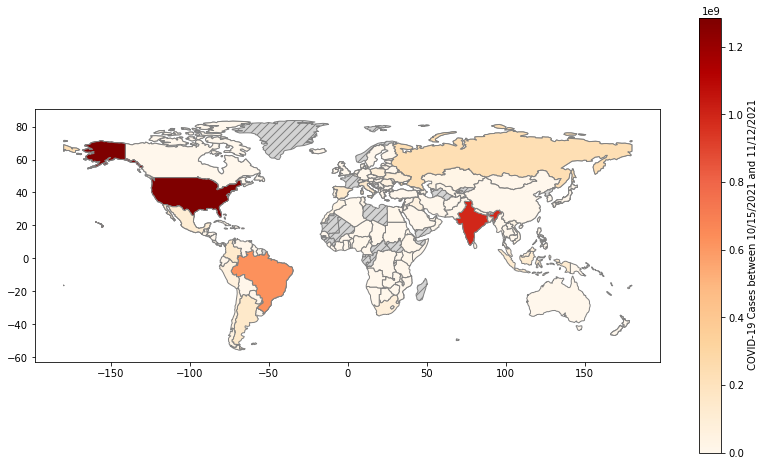

In [85]:

test = test[(test.pop_est>0) & (test.name!="Antarctica")]
test.plot(
    column="Confirmed",
    legend=True,
    cmap='OrRd',
    edgecolor="grey",
    figsize=(14, 8),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "grey",
        "hatch": "///",
        "label": "Missing values",
    },    
    legend_kwds = {'label': " COVID-19 Cases between 10/15/2021 and 11/12/2021"
                  },
);


### geo by state

In [8]:
#Read df parquet 
output_directory = 'gs://msca-bdp-students-bucket/shared_data/charleneyu/df_loc'
df_geocoord_f=spark.read.parquet(output_directory)

In [9]:
df_loc_us=df_geocoord_f.filter(df_geocoord_f.place_country_code=='US')

In [11]:
df_geocoord_f.select('place_full_name').filter(df_geocoord_f.place_country_code=='US').show(10)

+------------------+
|   place_full_name|
+------------------+
|  Blue Springs, MO|
|     Southlake, TX|
|    Burnsville, MN|
|        Denver, CO|
|     Virginia, USA|
|Council Bluffs, IA|
|  Picnic Point, WA|
|     Las Vegas, NV|
|       Houston, TX|
|   Mill Valley, CA|
+------------------+
only showing top 10 rows



In [10]:
print(df_loc_us.count())
print(df_loc_us.filter(df_loc_us.coordinates_coordinates.isNotNull()).count())
print(df_loc_us.filter(df_loc_us.geo_coordinates.isNotNull()).count())
print(df_loc_us.filter(df_loc_us.place_bounding_box.isNotNull()).count())

34819
981
981
34819


In [12]:
df_loc_us=df_loc_us[['id_str','place_bounding_box','place_country']]

In [13]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import pyspark.sql.functions as f
from itertools import chain
from pyspark.sql.functions import create_map, lit

take_first = udf(lambda rows: [  rows[0][0][0][0] ], ArrayType(StringType()))
take_second = udf(lambda rows: [  rows[0][0][0][1] ], ArrayType(StringType()))

df_loc_us=df_loc_us.withColumn("long", take_first("place_bounding_box")).\
withColumn("lat", take_second("place_bounding_box"))
#df_dups_30.withColumn("type_user", f.col("text_A")[0]).show()

In [14]:
df_loc_us_pd=df_loc_us[['id_str','long','lat']].toPandas()
df_loc_us_pd['long']=df_loc_us_pd.long.apply(''.join)
df_loc_us_pd['lat']=df_loc_us_pd.lat.apply(''.join)

In [35]:
df_loc_us_pd=df_loc_us_pd.round(2)

In [16]:
df_loc_us_pd['long']=pd.to_numeric(df_loc_us_pd["long"], downcast="float")
df_loc_us_pd['lat']=pd.to_numeric(df_loc_us_pd["lat"], downcast="float")

In [40]:
df_loc_us_pd=df_loc_us_pd.groupby(['long','lat']).count()

In [41]:
df_loc_us_pd=df_loc_us_pd.reset_index()

In [57]:
df_loc_us_pd.to_csv('long_lat.csv')

In [81]:
#!pip install plotly
#!pip install cufflinks

In [51]:
import plotly.express as px
px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.scatter_mapbox(df_loc_us_pd, lat="lat", lon="long")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

FileNotFoundError: [Errno 2] No such file or directory: '.mapbox_token'

In [55]:
import pandas as pd
us_cities = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/us-cities-top-1k.csv")

import plotly.express as px

fig = px.scatter_mapbox(us_cities, lat="lat", lon="lon", hover_name="City", hover_data=["State", "Population"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [48]:
import plotly.graph_objects as go

import pandas as pd

fig = go.Figure(data=go.Scattergeo(
        lon = df_loc_us_pd['long'],
        lat = df_loc_us_pd['lat'],
        #text = df['text'],
        mode = 'markers',
        #marker_color = df['cnt'],
        ))

fig.update_layout(
        title = 'Most trafficked US airports<br>(Hover for airport names)',
        geo_scope='usa',
    )
fig.show()

### USA Cases

In [18]:
urls_us=r'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
df_us = pd.read_csv(urls_us) 
df_us_cleaned=df_us[[ 'Province_State',\
             '10/15/21', '10/16/21', '10/17/21', '10/18/21', '10/19/21', '10/20/21',\
             '10/21/21', '10/22/21','10/23/21','10/24/21','10/25/21',\
             '10/26/21', '10/27/21', '10/28/21', '10/29/21','10/30/21',\
             '11/1/21','11/2/21', '11/3/21', '11/4/21', '11/5/21', '11/6/21',\
             '11/7/21', '11/8/21', '11/9/21', '11/10/21', '11/11/21', '11/12/21']]

        UID iso2 iso3  code3    FIPS   Admin2 Province_State Country_Region  \
0  84001001   US  USA    840  1001.0  Autauga        Alabama             US   
1  84001003   US  USA    840  1003.0  Baldwin        Alabama             US   
2  84001005   US  USA    840  1005.0  Barbour        Alabama             US   

         Lat      Long_  ... 11/29/21  11/30/21  12/1/21  12/2/21  12/3/21  \
0  32.539527 -86.644082  ...    10517     10526    10527    10531    10545   
1  30.727750 -87.722071  ...    38085     38104    38123    38140    38171   
2  31.868263 -85.387129  ...     3695      3699     3700     3700     3701   

   12/4/21  12/5/21  12/6/21  12/7/21  12/8/21  
0    10560    10561    10562    10566    10575  
1    38195    38207    38215    38236    38247  
2     3706     3708     3708     3708     3712  

[3 rows x 698 columns]


In [23]:
df_us_cleaned=df_us_cleaned.groupby(['Province_State']).sum()
df_us_cleaned=df_us_cleaned.sum(axis=1)

In [25]:
df_us_cleaned=df_us_cleaned.reset_index()

In [31]:
df_us_cleaned.columns=['state','cases']

In [ ]:
#

In [27]:
import matplotlib.pyplot as plt
import geopandas

In [ ]:
import pathlib
path_object = pathlib.path(filename)
df = geopandas.read_file(path_object)

In [32]:
states = geopandas.read_file('https://github.com/joncutrer/geopandas-tutorial/tree/master/data/')

DriverError: '/vsimem/1b46b1b571fd48909bf3d10664832b9b' not recognized as a supported file format.

In [ ]:
state

In [ ]:
#graph
df_loc_covid_merge=df_loc_covid_comb.merge(iso2.toPandas(),on='place_country_code', how='left')
df_test_3  = world.merge(df_loc_covid_merge, on='iso_a3', how='left')
test = gpd.GeoDataFrame(df_test_3)

In [ ]:
state.plot(
    column="Confirmed",
    legend=True,
    cmap='OrRd',
    edgecolor="grey",
    figsize=(14, 8),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "grey",
        "hatch": "///",
        "label": "Missing values",
    },    
    legend_kwds = {'label': " COVID-19 Cases between 10/15/2021 and 11/12/2021"
                  },
);


## User Analysis

In [86]:
df_user_cleaned = df_user_f.select('id_str', 'text','retweeted','retweet_count','original_or_not','user_contributors_enabled'\
                         ,'user_description','user_favourites_count','user_followers_count'\
                         ,'user_friends_count','user_geo_enabled','user_id_str','user_listed_count','user_location'\
                         ,'user_name','user_screen_name','user_statuses_count','user_url','user_verified').\
withColumn("type_user", rand()).withColumn('user_description', lower(col('user_description')))

In [ ]:
df_user_cleaned.select('user_id_str').distinct().count()

3207714

In [ ]:
df_user_cleaned.count()

14943934

In [ ]:
df_user_cleaned.filter(df_user_cleaned.user_verified == 'True' ).count()

416355

In [ ]:
df_user_cleaned.filter(df_user_cleaned.user_verified == 'False').count()

14527579

In [ ]:
df_user_final=df_user_cleaned.withColumn("type_user", when((df_user_cleaned.user_verified == 'True' ) & (df_user_cleaned.user_url.contains('.gov')), "government").\
                                   when((df_user_cleaned.user_verified == 'True' ) & (df_user_cleaned.user_description.contains('news')), "news").\
                                   when((df_user_cleaned.user_verified == 'True' ) & (df_user_cleaned.user_description.contains('channel')), "news").\
                                   when((df_user_cleaned.user_verified == 'True' ) & (df_user_cleaned.user_description.contains('magazine')), "news").\
                                   when((df_user_cleaned.user_verified == 'True' ) & (df_user_cleaned.user_url.contains('.org')), "health_org").\
                                   when((df_user_cleaned.user_verified == 'True' ) & (df_user_cleaned.user_description.contains('hospital')), "health_org").\
                                   when((df_user_cleaned.user_verified == 'True' ) & (df_user_cleaned.user_description.contains('health')), "health_org").\
                                   when((df_user_cleaned.user_verified == 'True' ) & (df_user_cleaned.user_description.contains('official')), "government").\
                                   when(( df_user_cleaned.user_followers_count -df_user_cleaned.user_friends_count >1000 )&(df_user_cleaned.user_statuses_count>100000 ), "influencers").\
                                   otherwise('others'))

In [89]:
lsh_data_user_text=df_user_final.\
select('id_str', 'text','type_user','user_id_str','original_or_not').\
filter(df_user_final.original_or_not=='1')

#save table as parquet
output_directory = 'gs://msca-bdp-students-bucket/shared_data/charleneyu/lsh_data_user_text'
lsh_data_user_text.write.format("parquet").\
mode('overwrite').\
save(output_directory)

In [105]:
#test corr
#do not run
df_user_final_test_corr=df_user_final.filter(df_user_final.user_id_str.isNotNull()).\
groupBy('user_id_str','type_user','user_statuses_count','user_followers_count','user_favourites_count','user_friends_count').\
agg(sum('original_or_not').alias('original_tweet_count'),\
    count('original_or_not').alias('total_tweet_count'),\
    sum('retweet_count').alias('total_times_being_retweeted'))

In [90]:
#By message volume (original content) #By message retweet (how often their messages are being retweeted)
df_user_cleaned_influ=df_user_final.filter(df_user_final.user_id_str.isNotNull()).groupBy('user_id_str','type_user').agg(sum('original_or_not').alias('original_tweet_count'),\
                                                                                         count('original_or_not').alias('total_tweet_count'),\
                                                                                         sum('retweet_count').alias('total_times_being_retweeted'))

In [100]:
df_user_cleaned_influ_ct=df_user_cleaned_influ.groupBy('type_user').\
agg(sum('original_tweet_count').alias('original_tweet_count'),\
    sum('total_tweet_count').alias('total_tweet_count'),\
    sum('total_times_being_retweeted').alias('total_times_being_retweeted'),\
    count('user_id_str').alias('number_of_user') ).toPandas()


In [108]:
df_user_cleaned_influ_ct['original_tweet_per_user']=df_user_cleaned_influ_ct.original_tweet_count/df_user_cleaned_influ_ct.number_of_user

In [109]:
df_user_cleaned_influ_ct

,type_user,original_tweet_count,total_tweet_count,total_times_being_retweeted,number_of_user,original_tweet_per_user
0,news,146213,179693,0,12288,11.898844
1,others,3988948,14259820,0,3146835,1.267606
2,health_org,29218,50632,0,6659,4.387746
3,influencers,146998,488537,0,37216,3.949860
4,government,26251,40083,0,5532,4.745300


In [113]:
df_user_cleaned_influ_ct.to_csv('df_user_cleaned_influ_ct.csv')
df_user_cleaned_verified_ct.to_csv('df_user_cleaned_verified_ct.csv')

In [105]:
df_user_cleaned_verified_ct=df_user_cleaned.filter(df_user_cleaned.user_verified.isNotNull()).\
groupBy('user_verified').agg(sum('original_or_not').alias('original_tweet_count'),\
                                                   count('original_or_not').alias('total_tweet_count'),\
                                                   sum('retweet_count').alias('total_times_being_retweeted'),\
                             countDistinct('user_id_str').alias('number_of_user') ).toPandas()

In [111]:
df_user_cleaned_verified_ct

,user_verified,original_tweet_count,total_tweet_count,total_times_being_retweeted,number_of_user,original_tweet_per_user
0,True,282701,420902,0,55777,5.068415
1,False,4054927,14597863,0,3152150,1.286400


In [110]:
df_user_cleaned_verified_ct['original_tweet_per_user']=df_user_cleaned_verified_ct.original_tweet_count/df_user_cleaned_verified_ct.number_of_user


In [ ]:
df_user_cleaned_influ_ct.index=df_user_cleaned_influ_ct.type_user

<AxesSubplot:title={'center':'original_tweet_count by user types'}, ylabel='original_tweet_count'>

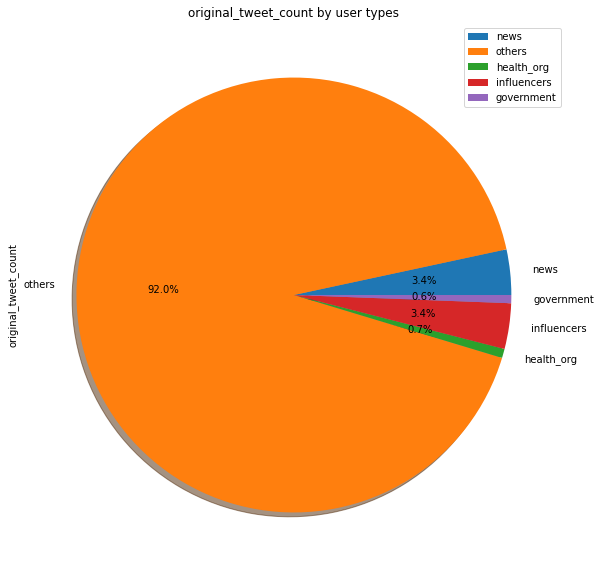

In [ ]:
df_user_cleaned_influ_ct.plot.pie(y='original_tweet_count', title="original_tweet_count by user types",\
                                  figsize=(15, 10),autopct='%1.1f%%',legend=True, shadow=True, startangle=0)

<AxesSubplot:title={'center':'total_tweet_count by user types'}, ylabel='total_tweet_count'>

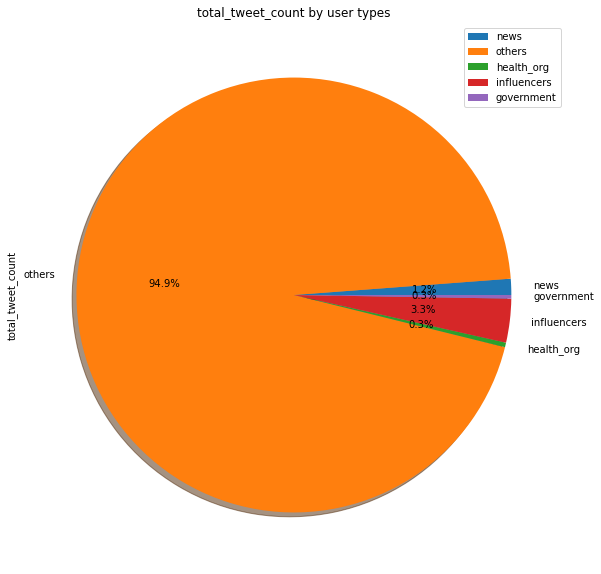

In [ ]:
df_user_cleaned_influ_ct.plot.pie(y='total_tweet_count', title="total_tweet_count by user types",\
                                  figsize=(15, 10),autopct='%1.1f%%',legend=True, shadow=True, startangle=0)

In [ ]:
df_user_cleaned_verified_ct.index=df_user_cleaned_verified_ct.user_verified

<AxesSubplot:title={'center':'original_tweet_count by user verification status (True/False)'}, ylabel='original_tweet_count'>

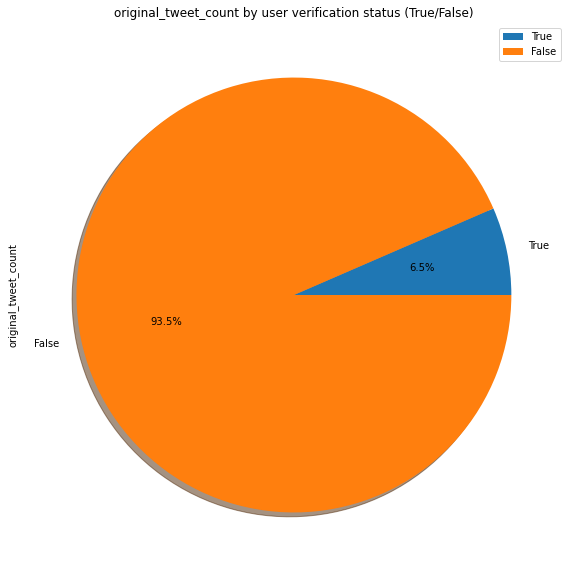

In [ ]:
df_user_cleaned_verified_ct.plot.pie(y='original_tweet_count', title="original_tweet_count by user verification status (True/False)",\
                                  figsize=(15, 10),autopct='%1.1f%%',legend=True, shadow=True, startangle=0)